# Inverted Cart Pendulum Simulation

Partial state measurement, where only the cart position is in the feedback.

In [2]:
import numpy as np  
import control as ctrl
import matplotlib.pyplot as plt
import math

# Continuous Time Model
State vector $\vec x$ = [$x$, $\dot x$, $\theta$, $\dot\theta$]

In [3]:
# Physical parameters +

m = 1 # pendulum mass
M = 5 # cart mass
L = 2 # length of pendulum
g = -10 
d = 1 # cart damping coefficient

# Simulation setup
t0 = 0
tf = 40
dt = 0.005                              # Sampling rate
T = np.arange(t0, tf+dt, dt).reshape(1,-1)            # Simulation time array

# Initial conditions
x0 = np.array([[-3], [0], [np.pi+0.2],[0]])
# Desired state
x_desire = np.array([[-1], [0], [np.pi], [0]])

# System state array - stores the history of ground truth
xt = x0.copy()                          # Instantaneous state
x = np.zeros((4,max(T.shape)))
x[:,0:1] = x0

# Desired linearized state - adjusted for the linearization point
yd = x_desire - np.array([[0], [0], [np.pi], [0]])

# Control input array - stores the history of control inputs
u = np.zeros(max(T.shape))

# Error array - stores history of difference between desired state and predicted state
e = np.zeros((4, max(T.shape)))

# Measurement array - stores history of position measurement
z = np.zeros((1, max(T.shape)))


# Kalman filter setup
# Prior mean - adjusted for linearization point
mu0 = x0 - np.array([[0], [0], [np.pi], [0]])     

# A priori variance
S0 = 0.1 * np.eye(4)                        

# Array of mean beliefs - stores the history of mu_bar
mu_bar = np.zeros((4, max(T.shape)))
# Array of EKF mean - stores the history of state means mu, with the first column being the intial belief, mu0
mu = np.zeros((4, max(T.shape)))              
mu[:, 0:1] = mu0
S = S0

In [4]:
# Linearized system model at the top equilibrium point
# (In other words, find the Jacobian of the motion model and evaluate at theta = pi and theta_dot = 0)
A_lin = np.array([[0, 1, 0, 0],
              [0, -d/M, -m*g/M, 0],
              [0, 0, 0, 1],
              [0, -d/(M*L), -(m+M)*g/(M*L), 0]])

B_lin = np.array([[0], 
              [1/M], 
              [0], 
              [1/(M*L)]])

C_lin = np.array([[1, 0, 0, 0]])

D_lin = np.array([[0]])

sys_ss = ctrl.ss(A_lin, B_lin, C_lin, D_lin)
sys_tf = ctrl.ss2tf(A_lin, B_lin, C_lin, D_lin)

lambda_ = np.linalg.eig(A_lin)[0]

# Pole placement
# p = np.array([-0.01, -0.02, -0.03, -0.04])
# p = np.array([-0.1, -0.2, -0.3, -0.4])
p = np.array([-1, -1.1, -1.2, -1.3])
# p = np.array([-2, -2.1, -2.2, -2.3])
# p = np.array([-3, -3.1, -3.2, -3.3])
# p = np.array([-3.5, -3.6, -3.7, -3.8])


K = ctrl.place(A_lin, B_lin, p)



## Controllability and Observability
If the controllability matrix and the observability matrices are of full rank (having n independent vectors, where n is the number of states) then the system is both controllable and observable. 

When the system is controllable, it means that

When the system is observable, it means that the full states can be derived by only measuring the states associated in matrix C

In [5]:
pc = np.linalg.matrix_rank(ctrl.ctrb(A_lin, B_lin))
print(f'Rank of controllability matrix: {pc:d}')
po = np.linalg.matrix_rank(ctrl.obsv(A_lin, C_lin))
print(f'Rank of observability matrix: {po:d}')

Rank of controllability matrix: 4
Rank of observability matrix: 4


# Discretized Model

Kalman Filter and Extended Kalman Filter are mainly implemented for discretized models of the form


$$ \begin{equation} \tag{Discrete linear systems}
\begin{split}
x_t & = A_d \cdot x_{t_1} + B_d \cdot u_t \\
y_t & = C_d \cdot x_t
\end{split}
\end{equation}
$$

or

$$ \begin{equation} \tag{Discrete nonlinear systems}
\begin{split}
x_t & = f(x_{t-1},u_t) \\
y_t & = h(x_t)
\end{split}
\end{equation}
$$

Therefore, in order to apply KF or EKF as a state estimator, the system model equations are to be discretized

In [6]:
# Discretized model for EKF implementation
sysd = ctrl.c2d(sys_ss, dt, 'zoh')
Ad = sysd.A
Bd = sysd.B
Cd = sysd.C
Dd = sysd.D

# Noise
Q = 0.1 * np.eye(4)
R = 0.01

In [7]:
for t in range(1, max(T.shape)):
    # Error
    e[:, t:t+1] = yd - mu[:, t - 1:t]                 # Dimension - 4x1 vector

    # Control input of the system
    u[t:t+1] = -np.dot(K, -e[:, t])                 # Dimension - 1x1 scalar
    # u[t] = 0

    # State update - Ground truth according to the system model
    q = np.dot(np.sqrt(Q), np.random.randn(4, 1))
    Sy = np.sin(xt[2])       # Abbreviation for sin(theta)
    Cy = np.cos(xt[2])       # Abbreviation for cos(theta)
    D = M + m * Sy ** 2
     
    dx = np.zeros((4,1))
    dx[0] = xt[1]
    dx[1] = (1/D) * (u[t:t+1] + m * Sy * (L * xt[3] ** 2 - g * Cy) - d * xt[1])
    dx[2] = xt[3] 
    dx[3] = (1/(L * D)) * ((m + M) * Sy * g - u[t:t+1] * Cy - m * Sy * Cy * L * xt[3] ** 2 + d * xt[1] * Cy)
    
    xt += dx * dt #+ q
    x[:, t:t+1] = xt        # True state

    # Measurement model - State measurement according to the measurement model
    r = np.sqrt(R) * np.random.randn(1)
    z[0,t:t+1] = np.dot(C_lin, (xt - np.array([[0], [0], [np.pi], [0]]))) + r



    # Kalman filter estimation
    # Prediction update
    mup = np.dot(Ad, mu[:,t - 1:t]) + np.dot(Bd, u[t:t+1]).reshape(-1,1)
    Sp = np.dot(Ad, np.dot(S, Ad.T)) + Q

    # Kalman gain
    Kg = np.dot(Sp, np.dot(Cd.T, np.linalg.inv(np.dot(Cd, np.dot(Sp, Cd.T)) + R)))

    # Measurement update of the state mean
    mu[:, t:t+1] = mup + np.dot(Kg, (z[0, t:t+1] - np.dot(Cd, mup)))

    # Update state uncertainty
    S = np.dot(np.eye(4) - np.dot(Kg, Cd), Sp)


# Plotting

The first plot below shows the state of the system over time

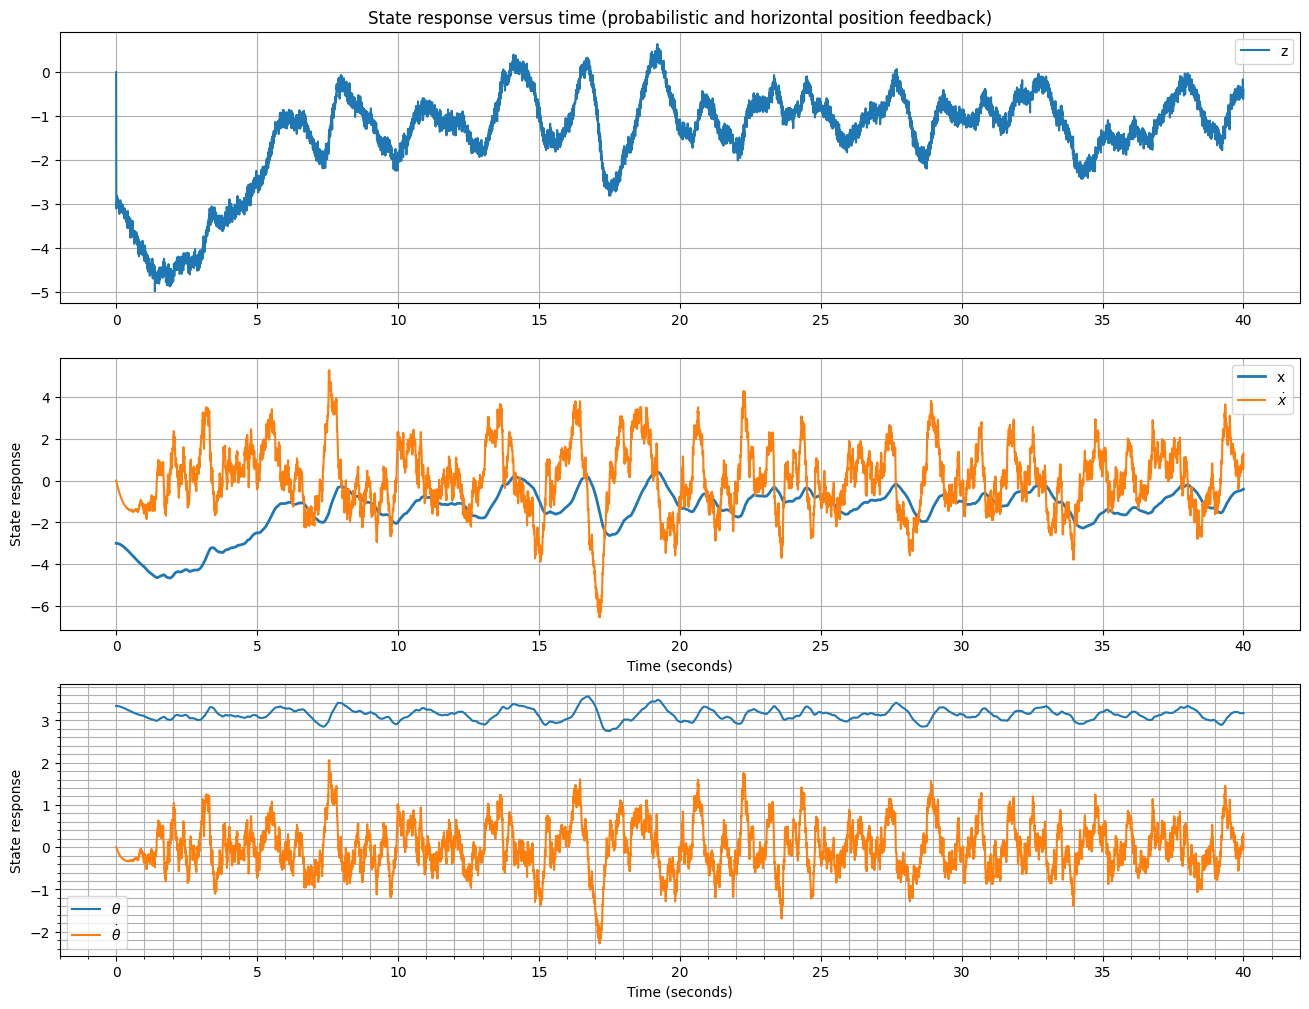

In [15]:
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plt.plot(T[0], z[0], label='z')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.title('State response versus time (probabilistic and horizontal position feedback)')

plt.subplot(3,1,2)
plt.plot(T[0], x[0, :], label = 'x', linewidth=2)
plt.plot(T[0], x[1, :], label = '$\dot x$')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('Time (seconds)')
plt.ylabel('State response')

plt.subplot(3,1,3)
plt.plot(T[0], x[2, :], label = r'$\theta$')
plt.plot(T[0], x[3, :], label = r'$\dot \theta$')
plt.legend(loc='best', fontsize=10)
plt.minorticks_on()
plt.grid(which = 'both')
plt.xlabel('Time (seconds)')
plt.ylabel('State response')


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


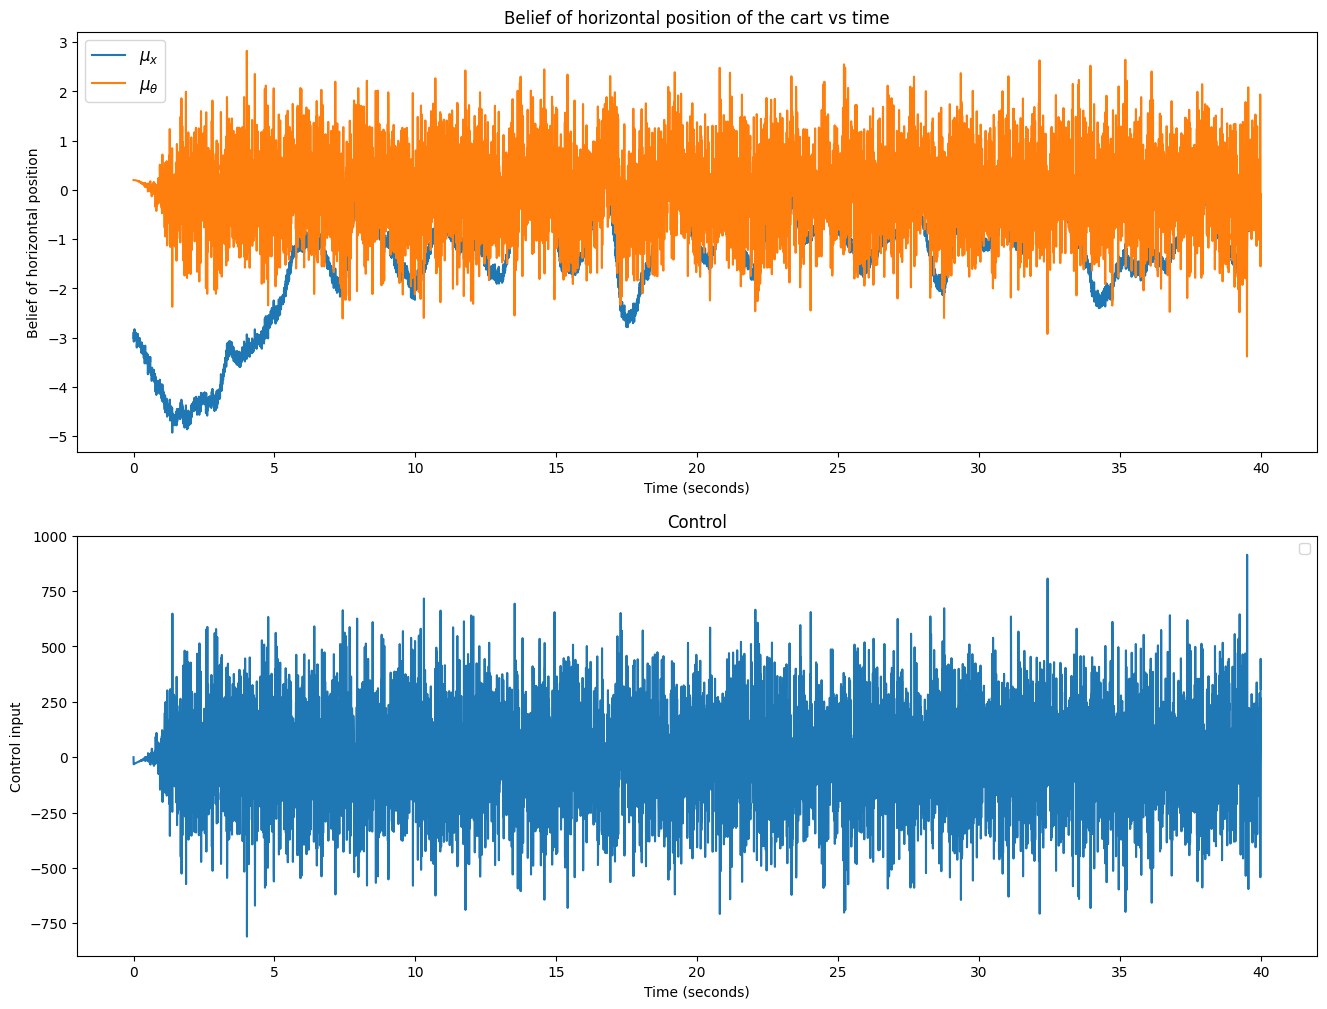

In [19]:
# Plotting Results
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.plot(T[0], mu[0, :], label = r'$\mu_x$')
plt.plot(T[0], mu[2, :], label = r'$\mu_{\theta}$')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Time (seconds)')
plt.ylabel('Belief of horizontal position')
plt.title('Belief of horizontal position of the cart vs time')

plt.subplot(2, 1, 2)
plt.plot(T[0], u)
plt.legend(loc='best')
plt.xlabel('Time (seconds)')
plt.ylabel('Control input')
plt.title('Control')

plt.show()